In [2]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import os, shutil
from os import walk
import cv2


In [3]:
dataset_df = pd.read_csv('icml_face_data.csv')
dataset_df

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [4]:
# remove the surprise data
dataset_df = dataset_df[dataset_df['emotion'] !=5]
# reclassify the images to unhappy:0/ happy:1/ neutral:2
dataset_df['emotion_new']  = [ 1 if x==3 else ( 2 if x==6 else 0) for x in dataset_df.emotion]

<ipython-input-4-88bb09801077>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df['emotion_new']  = [ 1 if x==3 else ( 2 if x==6 else 0) for x in dataset_df.emotion]


In [5]:
dataset_df.columns= dataset_df.columns.str.replace(' ', '')
dataset_df.emotion_new.value_counts()

0    16698
1     8989
2     6198
Name: emotion_new, dtype: int64

In [6]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion_new'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) / 255.0
        image_array[i] = image
    
    image_array = image_array.reshape((-1, 48, 48, 1))
    return image_array, image_label

In [7]:
def plot_distribution(counts_dict, labels):
  sd_counts_dict = {k : counts_dict[k] for k in sorted(counts_dict)}

  keys = sd_counts_dict.keys()
  values = sd_counts_dict.values()

  plt.figure(figsize=[8,6])
  plt.bar(keys, values, tick_label=labels)
  plt.title('Emotion Label Counts')
  plt.grid(b=None)
  plt.show();

In [10]:
from tensorflow.keras.utils import to_categorical

X_train, y_train = prepare_data(dataset_df[dataset_df['Usage']=='Training'])
X_test, y_test = prepare_data(dataset_df[dataset_df['Usage']=='PublicTest'])

X_train = np.repeat(X_train, 3, axis=-1)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

total train items:25538


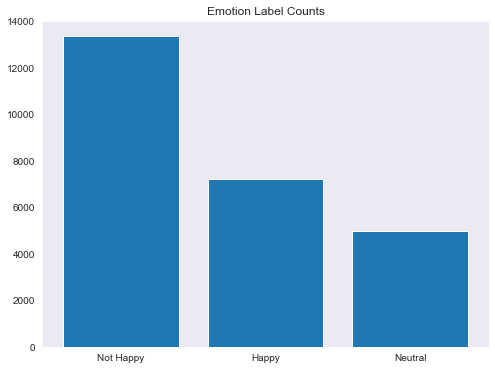

In [11]:
counts_dict = pd.DataFrame(y_train, columns=['emotion'])['emotion'].value_counts().to_dict()
emotions = ['Not Happy','Happy','Neutral']
print(f"total train items:{y_train.shape[0]}")
plot_distribution(counts_dict, emotions)

total Test items:3174


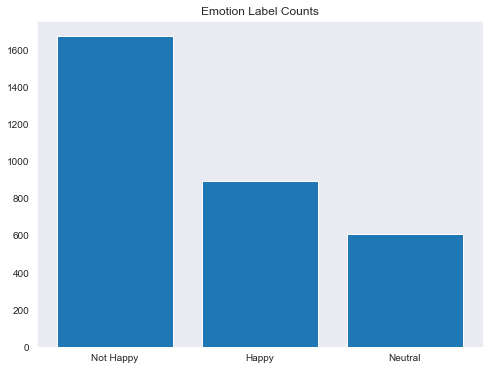

In [12]:
counts_dict = pd.DataFrame(y_test, columns=['emotion'])['emotion'].value_counts().to_dict()
emotions = ['Not Happy','Happy','Neutral']
print(f"total Test items:{y_test.shape[0]}")
plot_distribution(counts_dict, emotions)

In [13]:
emotion_cat = {0:'unhappy', 1:'happy', 2:'neutral'}
y_train_df = pd.DataFrame(y_train, columns=['emotion'])

def plot_all_emotions(img_num=3):
    fig, axs = plt.subplots(len(emotion_cat), img_num, figsize=(8,8))
    axs = axs.ravel()
    pos=0
    for emotion in range(data_df.emotion_new.nunique()):
        idx_arr = y_train_df[y_train_df['emotion']==emotion].index
        for img_idx in range(img_num):
            idx = idx_arr[img_idx]
            axs[pos].imshow(X_train[idx][:,:,0], cmap='gray')
            axs[pos].set_title(emotion_cat[emotion])
            axs[pos].set_xticklabels([])
            axs[pos].set_yticklabels([])
            pos+=1

def plot_per_emotion(emotion=0, img_num=3, init_idx=0):
    fig, axs = plt.subplots(1, img_num, figsize=(16, 16))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
              
    pos=0
    idx_arr = y_train_df[y_train_df['emotion']==emotion].index
    for img_idx in range(img_num):
        idx = idx_arr[img_idx+init_idx]
        axs[pos].imshow(X_train[idx][:,:,0], cmap='gray')
        axs[pos].set_title(emotion_cat[emotion])
        axs[pos].set_xticklabels([])
        axs[pos].set_yticklabels([])
        pos+=1

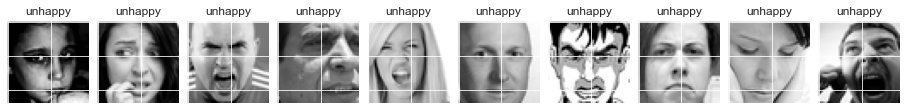

In [14]:
plot_per_emotion(emotion=0, img_num=10, init_idx=10)

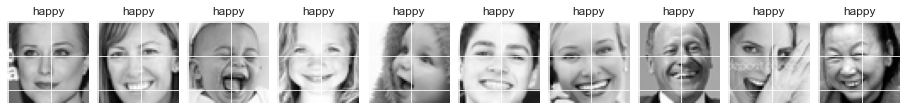

In [15]:
plot_per_emotion(emotion=1, img_num=10, init_idx=10)

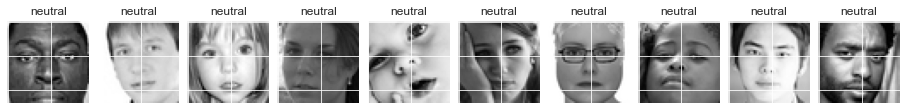

In [16]:
plot_per_emotion(emotion=2, img_num=10, init_idx=10)

**Simple NN Model**

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout
from tensorflow.keras.applications import mobilenet_v2, VGG16

In [22]:
model_leakyReku = Sequential()
model_leakyReku.add(Conv2D(32, (3, 3), activation=layers.LeakyReLU(alpha=0.2), input_shape=(48, 48, 3)))
model_leakyReku.add(MaxPooling2D(pool_size=(2,2)))
model_leakyReku.add(Dropout(0.25))
model_leakyReku.add(Conv2D(64, (3, 3), activation=layers.LeakyReLU(alpha=0.2), padding='same'))
model_leakyReku.add(MaxPooling2D(pool_size=(2,2)))
model_leakyReku.add(Dropout(0.25))
model_leakyReku.add(Flatten())
model_leakyReku.add(Dense(64, activation=layers.LeakyReLU(alpha=0.2)))
model_leakyReku.add(Dense(3, activation='softmax'))

model_leakyReku.compile(
    loss='categorical_crossentropy',
    optimizer='nadam',
    metrics=['accuracy'],
)

model_leakyReku.summary()


history_leakyReku = model_leakyReku.fit(X_train, y_train_cat, epochs=30, verbose=1, validation_split=0.25,
                    callbacks=[
                        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
                        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
                    ]
                   )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 64)        0

In [23]:
model_leakyReku.save('FER_model_RGB.h5')

### Evaluate the model

In [24]:
sns.set_style("whitegrid")
def plt_model_score(history):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    ax1.plot(epochs, acc, label='Train Accuracy')
    ax1.plot(epochs, val_acc, label='Val Accuracy')
    ax1.legend()
    ax1.grid(b=None)
    ax2.plot(epochs, loss, label='Train Loss')
    ax2.plot(epochs, val_loss, label='Val Loss')
    ax2.grid(b=None)

    ax2.legend();

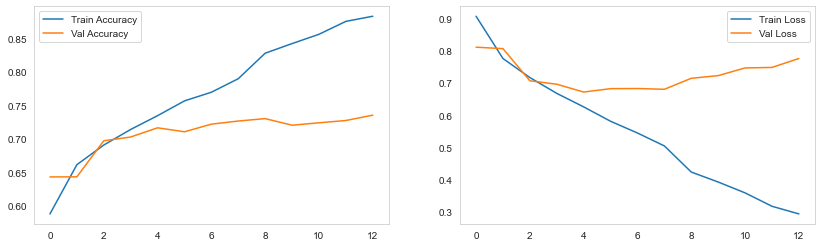

In [25]:
plt_model_score(history_leakyReku)

In [26]:
history_leakyReku.history['accuracy']

[0.5874797701835632,
 0.6612541079521179,
 0.6907011866569519,
 0.7140395641326904,
 0.7347151637077332,
 0.7568526864051819,
 0.7698532938957214,
 0.7901111841201782,
 0.8283297419548035,
 0.8427400588989258,
 0.8566803932189941,
 0.8760507702827454,
 0.8837257623672485]

In [27]:
np.mean(history_leakyReku.history['accuracy'])

0.7686564372136042

In [29]:
X_test = np.repeat(X_test, 3, axis=-1)
test_loss, test_acc = model_leakyReku.evaluate(X_test, y_test_cat)

100/100 [==============================] - 2s 15ms/step - loss: 0.6770 - accuracy: 0.7079


Test Accracy = 0.71


<ipython-input-30-f198960062a4>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


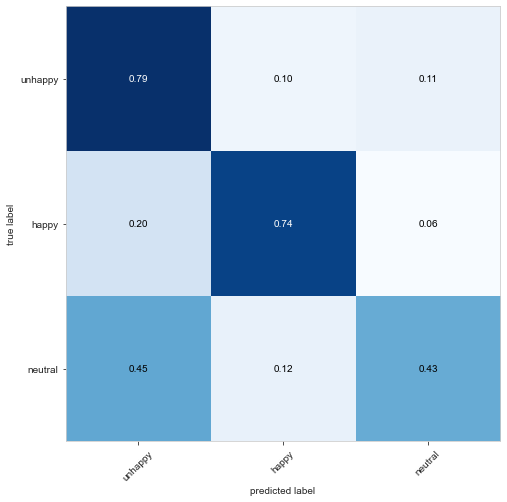

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

predictions = model_leakyReku.predict(X_test)

y_pred = [np.argmax(probs) for probs in predictions]

accuracy = accuracy_score(y_test, y_pred)
print("Test Accracy = %.2f" % accuracy)

confusion_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plot_confusion_matrix(confusion_matrix,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotion_cat.values(),
                                figsize=(8, 8))
fig.show()

In [33]:
def plot_image_and_emotion(X_test, y_test, predictions, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
    
    bar_label = emotion_cat.values()
    
    axs[0].imshow(X_test[image_number], 'gray')
    axs[0].set_title(emotion_cat[y_test[image_number]])
    print(emotion_cat[y_pred[image_number]])
    axs[1].bar(bar_label, predictions[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    

happy


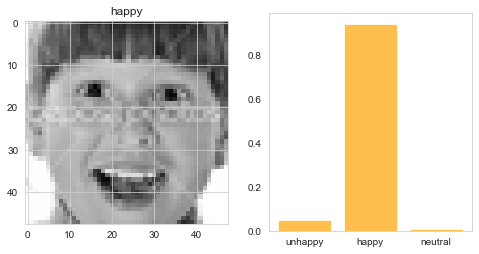

In [34]:
plot_image_and_emotion(X_test, y_test, predictions, 111)

unhappy


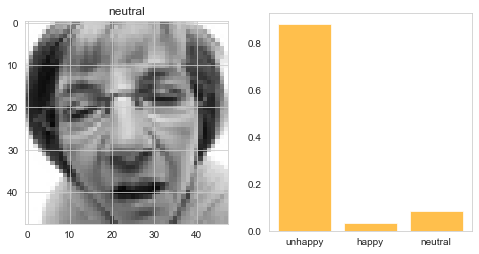

In [35]:
plot_image_and_emotion(X_test, y_test, predictions, 2340)

neutral


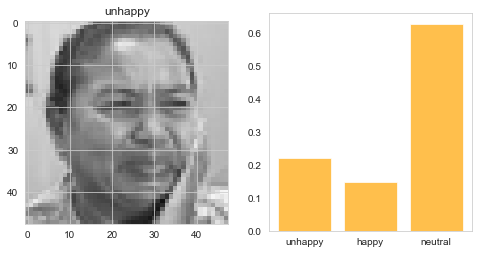

In [36]:
plot_image_and_emotion(X_test, y_test, predictions, 1987)

#### test other face images

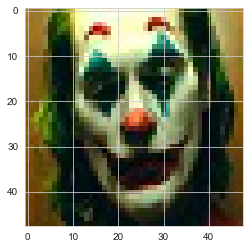

In [94]:
from keras.preprocessing.image import load_img, img_to_array
from os import walk
from skimage import io

test_img_array = []

files = []
test_filenames = next(walk("./model_test_images/"), (None, None, []))[2]


for f in test_filenames:
    pic = load_img('./model_test_images/{0}'.format(f))
    pixels = np.array(pic.getdata())
    test_img_array.append(pixels.reshape(48,48,3))
    plt.imshow(pixels.reshape(48,48,3))


In [95]:
test_img_label = [1, 1, 0, 2]
test_img_label = np.array(test_img_label)
test_img_predict = model_leakyReku.predict(np.array(test_img_array))
test_img_predict

array([[3.739889e-33, 0.000000e+00, 1.000000e+00],
       [0.000000e+00, 1.000000e+00, 0.000000e+00],
       [1.000000e+00, 0.000000e+00, 0.000000e+00],
       [0.000000e+00, 1.000000e+00, 0.000000e+00]], dtype=float32)

unhappy


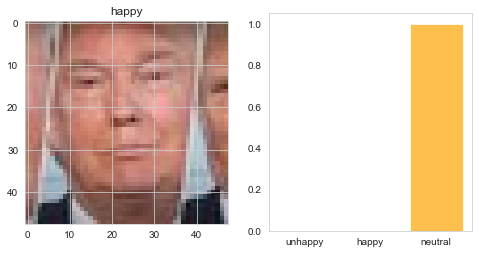

In [96]:
plot_image_and_emotion(test_img_array, test_img_label, test_img_predict, 0)

unhappy


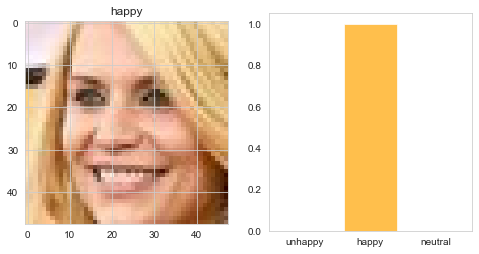

In [97]:
plot_image_and_emotion(test_img_array, test_img_label, test_img_predict, 1)

unhappy


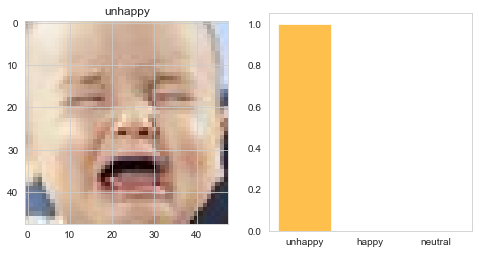

In [98]:
plot_image_and_emotion(test_img_array, test_img_label, test_img_predict, 2)

unhappy


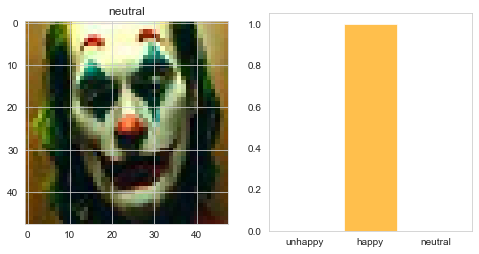

In [99]:
plot_image_and_emotion(test_img_array, test_img_label, test_img_predict, 3)

#### Transfered NN
> the result is not as good as self build NN. stick with the previous build model_leakyRelu

In [133]:
X_train_Transferred = np.repeat(X_train, 3, axis=-1)

In [134]:
from tensorflow.keras.applications import VGG16, mobilenet_v2, resnet50
from tensorflow.keras.layers import ZeroPadding2D, Dropout 


base = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))

# Freeze convolutional layers
for layer in base.layers:
    layer.trainable = False  
    
NN_transfer = Sequential()
NN_transfer.add(base)
NN_transfer.add(Flatten())
NN_transfer.add(Dense(1000,   activation='relu'))

NN_transfer.add(Dense(3, activation='softmax'))

#Default Adam(lr=0.001) 
optimizer = keras.optimizers.Adam(lr=0.001)

NN_transfer.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)
NN_transfer.summary()


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_30 (Flatten)        (None, 512)               0         
                                                                 
 dense_105 (Dense)           (None, 1000)              513000    
                                                                 
 dense_106 (Dense)           (None, 3)                 3003      
                                                                 
Total params: 15,230,691
Trainable params: 516,003
Non-trainable params: 14,714,688
_________________________________________________________________


In [135]:
# history_transfer = NN_transfer.fit(                       
#                         train_generator,
#                         steps_per_epoch=50,
#                         epochs=20,
#                         validation_data=val_generator,
#                         validation_steps =50,
#                         callbacks=[
#                                 keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
#                                 keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1)
#                                 ]
#                     )

history_transferred = NN_transfer.fit(X_train_Transferred, y_train_cat, epochs=30, verbose=1, validation_split=0.25,
                    callbacks=[
                        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
                        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
                    ]
                   )

Epoch 1/30
599/599 [==============================] - 211s 352ms/step - loss: 0.9298 - accuracy: 0.5722 - val_loss: 0.9351 - val_accuracy: 0.5563 - lr: 0.0010
Epoch 2/30
599/599 [==============================] - 203s 339ms/step - loss: 0.8801 - accuracy: 0.6019 - val_loss: 0.8796 - val_accuracy: 0.5975 - lr: 0.0010
Epoch 3/30
599/599 [==============================] - 210s 350ms/step - loss: 0.8495 - accuracy: 0.6204 - val_loss: 0.8632 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 4/30
599/599 [==============================] - 199s 333ms/step - loss: 0.8243 - accuracy: 0.6344 - val_loss: 0.8796 - val_accuracy: 0.6075 - lr: 0.0010
Epoch 5/30
599/599 [==============================] - 200s 334ms/step - loss: 0.8006 - accuracy: 0.6470 - val_loss: 0.8580 - val_accuracy: 0.6133 - lr: 0.0010
Epoch 6/30
599/599 [==============================] - 200s 334ms/step - loss: 0.7693 - accuracy: 0.6611 - val_loss: 0.8538 - val_accuracy: 0.6263 - lr: 0.0010
Epoch 7/30
599/599 [==========================

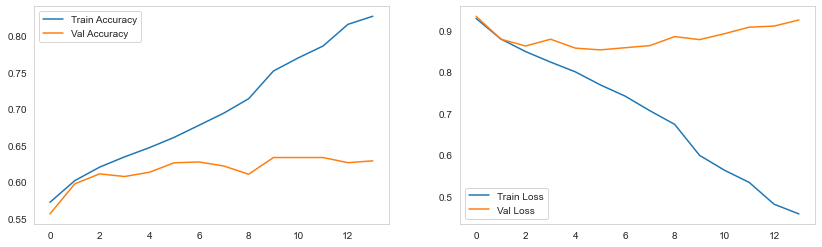

In [136]:
plt_model_score(history_transferred)

In [193]:
NN_transfer.save('transferred_model.h5')

#### data augmentation

In [50]:

# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1, 
#     height_shift_range=0.1,
#     rescale=1.0/255,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2
# )

In [70]:
# base_path = './input/'
# batch_size = 64


# train_generator = datagen.flow_from_directory(base_path + "train",
#                                           target_size=(48,48),
#                                           batch_size=batch_size,
#                                           seed=42,
#                                           shuffle=False,
#                                           subset='training',
#                                           class_mode='categorical')
# val_generator = datagen.flow_from_directory(base_path + "train",
#                                         target_size=(48,48),
#                                         batch_size=batch_size,
#                                         seed=42,
#                                         shuffle=False,
#                                         subset='validation',
#                                         class_mode='categorical')
# test_generator = datagen.flow_from_directory(base_path + "test",
#                                         target_size=(48,48),
#                                         batch_size=batch_size,
#                                         seed=42,
#                                         shuffle=False,
#                                         class_mode='categorical')

Found 32061 images belonging to 3 classes.
Found 8013 images belonging to 3 classes.
Found 3174 images belonging to 3 classes.


In [72]:
# model_leakyReku = Sequential()
# model_leakyReku.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3)))
# model_leakyReku.add(MaxPooling2D(2,2))

# model_leakyReku.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model_leakyReku.add(MaxPooling2D(2,2))

# model_leakyReku.add(Flatten())
# model_leakyReku.add(Dense(64, activation=layers.LeakyReLU(alpha=0.2)))

# # model_leakyReku.add(Dense(32, activation=layers.LeakyReLU(alpha=0.2)))

# model_leakyReku.add(Dense(3, activation='softmax'))

# model_leakyReku.compile(
#     loss='categorical_crossentropy',
#     optimizer='sgd',
#     metrics=['accuracy'],
# )

# model_leakyReku.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 46, 46, 64)        1792      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 flatten_25 (Flatten)        (None, 7744)              0         
                                                                 
 dense_95 (Dense)            (None, 64)              

In [41]:
# from tensorflow import keras

# history_leakyReku = model_leakyReku.fit(
#                         train_generator,
#                         steps_per_epoch=100, #train_generator.n//train_generator.batch_size,
#                         epochs=3,
#                         validation_data=val_generator,
#                         validation_steps = 50, # val_generator.n//val_generator.batch_size,
#                         callbacks=[
#                                 keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
#                                 keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1)
#                                 ]
#                         )

Epoch 1/3
100/100 [==============================] - 60s 594ms/step - loss: 1.1201 - accuracy: 0.2939 - val_loss: 1.1585 - val_accuracy: 9.3750e-04 - lr: 0.0100
Epoch 2/3
100/100 [==============================] - 56s 561ms/step - loss: 1.0850 - accuracy: 0.4530 - val_loss: 0.9217 - val_accuracy: 0.8555 - lr: 0.0100
Epoch 3/3
100/100 [==============================] - 55s 547ms/step - loss: 1.1072 - accuracy: 0.3093 - val_loss: 1.0823 - val_accuracy: 0.1445 - lr: 0.0100
